In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cd ..
!ls

drive  sample_data


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

# Step 1: Load Data
file_path = "...Data/rawdata/XLV/EBITDA_EV_Files/LLY_ebitda_ev.csv"
df = pd.read_csv(file_path, parse_dates=["datadate"], index_col="datadate")
df = df.asfreq('QE')

# Step 2: Remove Outliers using Winsorization
Q1 = df["EBITDA"].quantile(0.05)
Q3 = df["EBITDA"].quantile(0.95)
df["EBITDA_W"] = df["EBITDA"].clip(Q1, Q3)

In [ ]:
# Step 3: Initialize Rolling Window Parameters
train_length = 40  # 4seasons * 10years to train
test_length = 4     # next 4seasons to predict
step_size = 4       # jump 4predicted seasons for next round's predictions

# Setting up adf test
def adf_test(series):
    result = adfuller(series.dropna())
    return result[1]  # p-value

# New Section

In [ ]:
from tqdm import tqdm
from statsmodels.stats.diagnostic import acorr_ljungbox

sarima_orders = []
sarima_models = []
ljungbox_results = []

future_periods = 4
last_date = df.index[-1]  # make sure the last date's data is included
extra_dates = pd.date_range(start=last_date, periods=future_periods+1, freq="QE")[1:]

# 扩展 predictions，使其包含未来的索引
all_dates = pd.Index(df.index.tolist() + extra_dates.tolist())  # 确保索引合并正确
predictions = pd.DataFrame(index=all_dates, columns=["Predicted_EBITDA"])

for start in tqdm(range(0, len(df) - train_length + 1, step_size), desc="Rolling SARIMA"):
    print(f"\nRolling Window {start}: Training {start} to {start + train_length - 1}")

    # Step 4.1: choosing trainset
    train = df["EBITDA_W"].iloc[start : start + train_length]
    test_indices = all_dates[start + train_length : start + train_length + test_length]  # 预测未来 4 期
    print(f"Train set: {train.index.min()} to {train.index.max()}")

    # Step 4.2: ADF Test & Differencing
    d = 1 if adf_test(train) > 0.05 else 0
    print(f"ADF Test Completed, d={d}")

    # Step 4.3: AutoARIMA for Order Selection
    auto_model = auto_arima(train, seasonal=True, m=4, d=d, trace=False)
    best_order, best_seasonal_order = auto_model.order, auto_model.seasonal_order
    print(f"Best SARIMA Order: {best_order}, Seasonal Order: {best_seasonal_order}")

    # Step 4.4: 训练 SARIMA 模型
    sarima_model = sm.tsa.statespace.SARIMAX(
        train,
        order=best_order,
        seasonal_order=best_seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_result = sarima_model.fit(disp=False)
    print("SARIMA Model Fitted")

    # Step 4.5: 预测未来 4 期
    forecast = sarima_result.get_forecast(steps=test_length)
    forecast_mean = forecast.predicted_mean
    print(f"Predicted EBITDA for {list(test_indices)}: {list(forecast_mean.values)}")

    # Step 4.6: 存储预测值
    predictions.loc[test_indices, "Predicted_EBITDA"] = forecast_mean.values
    print("Prediction Stored\n")

    # Step 4.7: 计算 Ljung-Box 统计量
    residuals = sarima_result.resid
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    ljungbox_pval = lb_test["lb_pvalue"].values[0]
    ljungbox_results.append({
        "Window_Start": train.index.min(),
        "Window_End": train.index.max(),
        "LjungBox_pval": ljungbox_pval
    })
    print(f"Ljung-Box Test (p-value at lag 10): {ljungbox_pval}")

    # Step 4.8: 存储 SARIMA 参数
    sarima_orders.append({
        "Window_Start": train.index.min(),
        "Window_End": train.index.max(),
        "p": best_order[0], "d": best_order[1], "q": best_order[2],
        "P": best_seasonal_order[0], "D": best_seasonal_order[1], "Q": best_seasonal_order[2], "m": best_seasonal_order[3]
    })
    sarima_models.append(sarima_result)

print("Rolling Window SARIMA Training Completed.")

Rolling SARIMA:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Rolling Window 0: Training 0 to 39
Train set: 2006-03-31 00:00:00 to 2015-12-31 00:00:00
ADF Test Completed, d=0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (1, 0, 0), Seasonal Order: (1, 0, 0, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2016-03-31 00:00:00'), Timestamp('2016-06-30 00:00:00'), Timestamp('2016-09-30 00:00:00'), Timestamp('2016-12-31 00:00:00')]: [839.2751009967672, 818.8151249478691, 899.9870774532214, 658.4420640941407]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.7464097889351803

Rolling Window 4: Training 4 to 43
Train set: 2007-03-31 00:00:00 to 2016-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (0, 1, 1), Seasonal Order: (0, 0, 1, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2017-03-31 00:00:00'), Timestamp('2017-06-30 00:00:00'), Timestamp('2017-09-30 00:00:00'), Timestamp('2017-12-31 00:00:00')]: [1173.7788892966341, 1387.191175881492, 1293.2712850389541, 1402.6363878998286]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.4795828293977994

Rolling Window 8: Training 8 to 47
Train set: 2008-03-31 00:00:00 to 2017-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (0, 1, 1), Seasonal Order: (0, 0, 1, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2018-03-31 00:00:00'), Timestamp('2018-06-30 00:00:00'), Timestamp('2018-09-30 00:00:00'), Timestamp('2018-12-31 00:00:00')]: [750.2703070931849, 1221.1605743460432, 943.444240018252, 794.0617683908749]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.33588284422523734

Rolling Window 12: Training 12 to 51
Train set: 2009-03-31 00:00:00 to 2018-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (1, 1, 1), Seasonal Order: (0, 0, 0, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2019-03-31 00:00:00'), Timestamp('2019-06-30 00:00:00'), Timestamp('2019-09-30 00:00:00'), Timestamp('2019-12-31 00:00:00')]: [1398.810675750041, 1372.711099492255, 1383.8944901285922, 1379.1025262710332]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.962092200771038

Rolling Window 16: Training 16 to 55
Train set: 2010-03-31 00:00:00 to 2019-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (1, 1, 1), Seasonal Order: (0, 0, 0, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2020-03-31 00:00:00'), Timestamp('2020-06-30 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-12-31 00:00:00')]: [1911.8690423960034, 2007.1933110301484, 1958.8162154408678, 1983.3676063005935]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.9347968138031129

Rolling Window 20: Training 20 to 59
Train set: 2011-03-31 00:00:00 to 2020-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (1, 1, 1), Seasonal Order: (0, 0, 0, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2021-03-31 00:00:00'), Timestamp('2021-06-30 00:00:00'), Timestamp('2021-09-30 00:00:00'), Timestamp('2021-12-31 00:00:00')]: [2029.4440431888786, 2504.142978919003, 2252.7483428137443, 2385.883806800597]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.9862645664598142

Rolling Window 24: Training 24 to 63
Train set: 2012-03-31 00:00:00 to 2021-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (1, 1, 1), Seasonal Order: (0, 0, 0, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2022-03-31 00:00:00'), Timestamp('2022-06-30 00:00:00'), Timestamp('2022-09-30 00:00:00'), Timestamp('2022-12-31 00:00:00')]: [1915.3183957383176, 2139.8127168707774, 2028.2594802066028, 2083.6912815433984]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.7493001376631158

Rolling Window 28: Training 28 to 67
Train set: 2013-03-31 00:00:00 to 2022-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (0, 1, 2), Seasonal Order: (0, 0, 0, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2023-03-31 00:00:00'), Timestamp('2023-06-30 00:00:00'), Timestamp('2023-09-30 00:00:00'), Timestamp('2023-12-31 00:00:00')]: [1974.664846762412, 2153.1322311965664, 2153.1322311965664, 2153.1322311965664]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.9826356392986305

Rolling Window 32: Training 32 to 71
Train set: 2014-03-31 00:00:00 to 2023-12-31 00:00:00
ADF Test Completed, d=1


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Best SARIMA Order: (0, 1, 2), Seasonal Order: (0, 0, 0, 4)
SARIMA Model Fitted
Predicted EBITDA for [Timestamp('2024-03-31 00:00:00'), Timestamp('2024-06-30 00:00:00'), Timestamp('2024-09-30 00:00:00'), Timestamp('2024-12-31 00:00:00')]: [1864.5810782104934, 2094.270666615827, 2094.270666615827, 2094.270666615827]
Prediction Stored

Ljung-Box Test (p-value at lag 10): 0.9566751887686205
Rolling Window SARIMA Training Completed.


In [ ]:
# output SARIMA 公式 + 参数 + Ljung-Box 结果
print("\nSARIMA Model Formulas & Parameters for Each Rolling Window:")
for i, (row, model, lb) in enumerate(zip(sarima_orders, sarima_models, ljungbox_results)):
    formula = f"SARIMA({row['p']}, {row['d']}, {row['q']}) x ({row['P']}, {row['D']}, {row['Q']}, {row['m']})"
    params = model.params
    param_str = ", ".join([f"{k}: {v:.4f}" for k, v in params.items()])

    print(f"Window {i+1} ({row['Window_Start']} to {row['Window_End']}): {formula}")
    print(f"  Parameters: {param_str}")
    print(f"  Ljung-Box Test p-value: {lb['LjungBox_pval']:.4f}\n")


SARIMA Model Formulas & Parameters for Each Rolling Window:
Window 1 (2006-03-31 00:00:00 to 2015-12-31 00:00:00): SARIMA(1, 0, 0) x (1, 0, 0, 4)
  Parameters: ar.L1: 0.9124, ar.S.L4: 0.3330, sigma2: 205868.9830
  Ljung-Box Test p-value: 0.7464

Window 2 (2007-03-31 00:00:00 to 2016-12-31 00:00:00): SARIMA(0, 1, 1) x (0, 0, 1, 4)
  Parameters: ma.L1: -0.5562, ma.S.L4: 0.5428, sigma2: 132273.9902
  Ljung-Box Test p-value: 0.4796

Window 3 (2008-03-31 00:00:00 to 2017-12-31 00:00:00): SARIMA(0, 1, 1) x (0, 0, 1, 4)
  Parameters: ma.L1: -0.6938, ma.S.L4: 0.4475, sigma2: 124993.3825
  Ljung-Box Test p-value: 0.3359

Window 4 (2009-03-31 00:00:00 to 2018-12-31 00:00:00): SARIMA(1, 1, 1) x (0, 0, 0, 4)
  Parameters: ar.L1: -0.4285, ma.L1: -0.5353, sigma2: 161770.4539
  Ljung-Box Test p-value: 0.9621

Window 5 (2010-03-31 00:00:00 to 2019-12-31 00:00:00): SARIMA(1, 1, 1) x (0, 0, 0, 4)
  Parameters: ar.L1: -0.5075, ma.L1: -0.3825, sigma2: 218312.5993
  Ljung-Box Test p-value: 0.9348

Window 

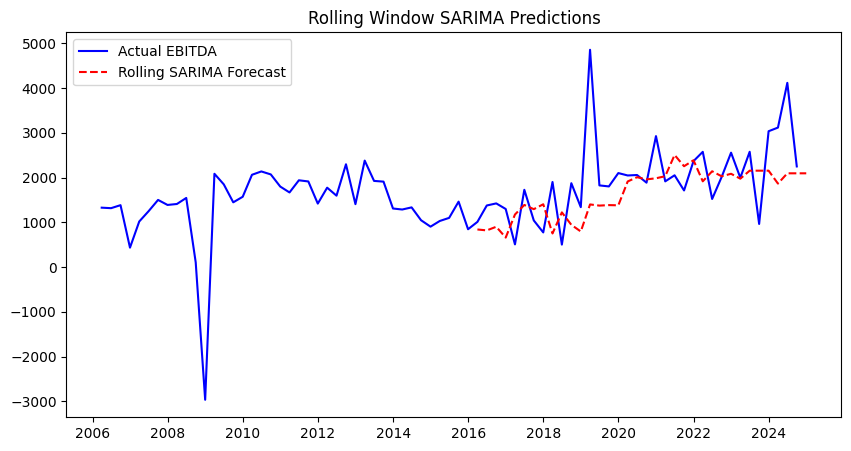

In [ ]:
# Step 8: Plot Results
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["EBITDA"], label="Actual EBITDA", color='blue')
plt.plot(predictions.index, predictions["Predicted_EBITDA"], label="Rolling SARIMA Forecast", linestyle="dashed", color='red')
plt.title("Rolling Window SARIMA Predictions")
plt.legend()
plt.show()

In [ ]:
print(predictions.tail(10))

           Predicted_EBITDA
2023-06-30      2153.132231
2023-09-30      2153.132231
2023-12-31      2153.132231
2024-03-31      1864.581078
2024-06-30      2094.270667
2024-09-30      2094.270667
2024-12-31      2094.270667
2025-03-31              NaN
2025-06-30              NaN
2025-09-30              NaN
